In [1]:
#Plot of confirmed Corona cases in selected countries.
#Last update: 2020-03-14, 8:05, JL

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#https://github.com/CSSEGISandData/COVID-19
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

In [2]:
df = pd.read_csv(url,index_col=None)
df=df.drop(['Lat','Long'],axis=1)
df=df.set_index([*df.columns[:2]])
df=df.stack().reset_index()
df.columns=['state','country','date','cases']
df.date=pd.to_datetime(df.date)
df=df.groupby(['country','date']).sum().reset_index()
df.tail()

,country,date,cases
6495,Vietnam,2020-03-09,30
6496,Vietnam,2020-03-10,31
6497,Vietnam,2020-03-11,38
6498,Vietnam,2020-03-12,39
6499,Vietnam,2020-03-13,47


In [3]:
allCountries=sorted(df.country.unique())
for a,b,c in zip(allCountries[::3],allCountries[1::3],allCountries[2::3]):
    print('{:<30}{:<30}{:<}'.format(a,b,c))

Afghanistan                   Albania                       Algeria
Andorra                       Antigua and Barbuda           Argentina
Armenia                       Aruba                         Australia
Austria                       Azerbaijan                    Bahrain
Bangladesh                    Belarus                       Belgium
Bhutan                        Bolivia                       Bosnia and Herzegovina
Brazil                        Brunei                        Bulgaria
Burkina Faso                  Cambodia                      Cameroon
Canada                        Cayman Islands                Chile
China                         Colombia                      Congo (Kinshasa)
Costa Rica                    Cote d'Ivoire                 Croatia
Cruise Ship                   Cuba                          Cyprus
Czechia                       Denmark                       Dominican Republic
Ecuador                       Egypt                         Estonia
Ethiopia  

In [4]:
plotCountries=['Germany','Italy','Spain','Iran','Japan','Portugal', 'Korea, South','US']
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')

C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\jlsocial\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


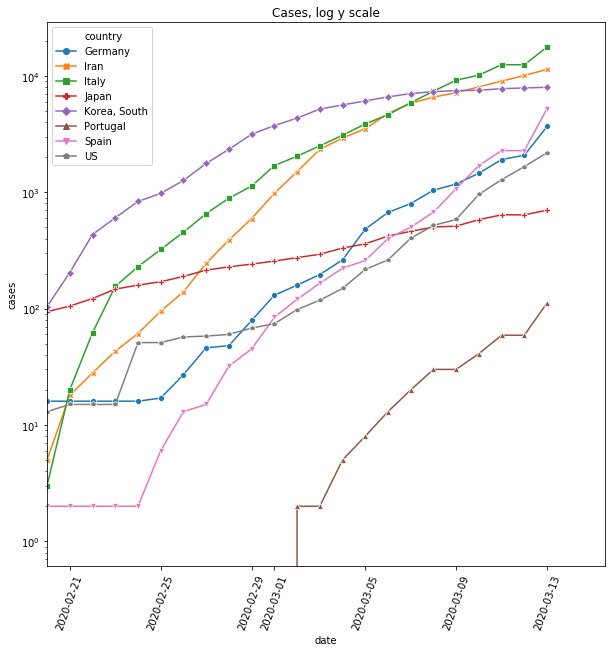

In [5]:
plt.subplots(figsize=(10,10))
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)
ax = g.axes
ax.set_yscale('log')
plt.title('Cases, log y scale')
plt.xlim(left=plotStartDate)
plt.xticks(rotation=70);

In [6]:
df.date.max()

Timestamp('2020-03-13 00:00:00')

Note similar slopes of european countries. Italy took of earlier

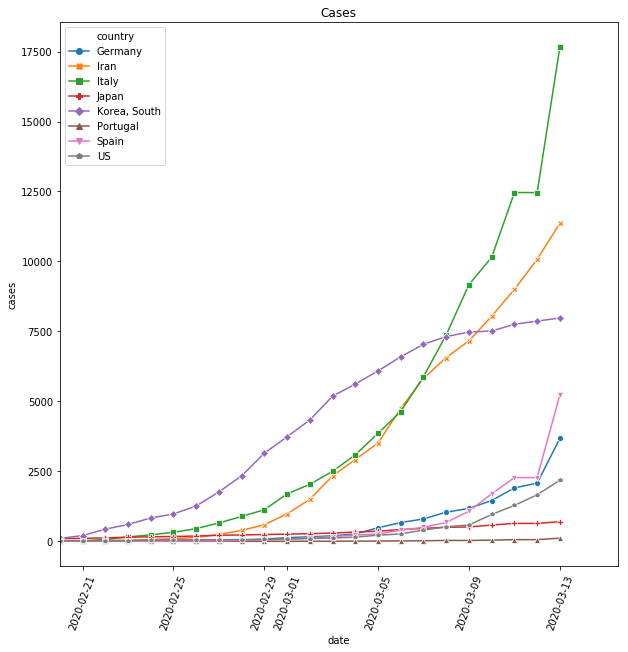

In [7]:
plt.subplots(figsize=(10,10))
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.title('Cases');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

In [8]:
ix=df.country.isin([plotCountries[0]])
df.loc[ix][-3:]

,country,date,cases
2493,Germany,2020-03-11,1908
2494,Germany,2020-03-12,2078
2495,Germany,2020-03-13,3675


In [9]:
ix=df.country.isin([plotCountries[-1]])
df.loc[ix][-3:]

,country,date,cases
6289,US,2020-03-11,1281
6290,US,2020-03-12,1663
6291,US,2020-03-13,2179


# Plot cases aligned to date of crossing 100 cases

Text(0.5, 0, 'days since 100 cases')

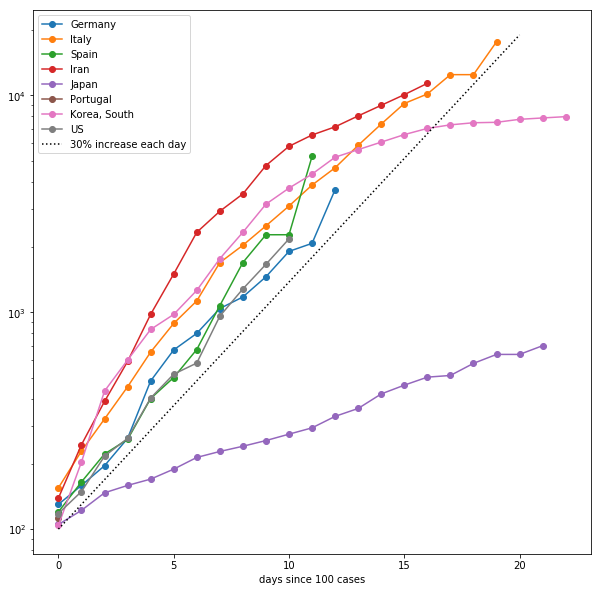

In [10]:
fix,ax=plt.subplots(figsize=(10,10))


for i,c in enumerate(plotCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        inflect=np.argmax(ts>100)
        ax.plot(ts[inflect:],'o-',label=c)
    
t=np.linspace(0,20,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend()
plt.xlabel('days since 100 cases')